# Compare cell lines and subtypes 

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model

# prediction stuff

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report,f1_score,PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error



# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-02-13 15:23:12.957458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 15:23:12.957932: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 15:23:12.960655: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 15:23:12.966903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739485392.976597 2034784 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739485392.97

In [2]:
## parameters
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"
consensus_ov_ex_path = f"{os.getcwd()}/../../data/bulk/schW_example_scores.tsv"
cell_line_expr_path = f"{os.getcwd()}/../../data/cell_line/GSE282041_expr.tsv"
cell_line_meta_path = f"{os.getcwd()}/../../data/cell_line/GSE282041_meta.tsv"


consensus_ov_ex_df = pd.read_csv(consensus_ov_ex_path, sep="\t")


exp_id = "all-cellType"
res_id = "cellType" # cellType subtype celltype_granular

curr_treatment = "drug"


pseudobulk_ids = ["GSE192898", "GSE154600", "GSE180661", "GSE217517", "GSE165897"]

tumor_cell_ids = ['Tumor_cell', "Epithelial cells", "Ovarian.cancer.cell",
                  "EOC"]

immune_cell_ids = ['B-cell', 'CD4+_T-cell',  'CD8+_T-cell', 'Macrophage',
                    'Monocyte', 'NK_cell', "CD8+ T-cells", "Macrophages", "Monocytes", 
                    "NK cells", "CD4+ T-cells", "B-cells",
                    "T.cell", "Monocyte", "B.cell", "Immune"]
stromal_cell_ids = ['Endothelial_cell', 'Fibroblast', "Endothelial cells", 
                  "Adipocytes", "Mesangial cells",
                  "Fibroblasts", "Endothelial.cell", "Stromal"]



In [3]:
# read in the cell line info
expr_cl_df = pd.read_csv(cell_line_expr_path, sep="\t")
meta_cl_df = pd.read_csv(cell_line_meta_path, sep="\t")

# convert index to string
meta_cl_df['index'] = pd.Series(np.array(range(meta_cl_df.shape[0])), dtype="string")
meta_cl_df = meta_cl_df.set_index('index')


# get gene ids
gene_ids_cl = expr_cl_df.gene_ids
expr_cl_df = expr_cl_df.drop(expr_cl_df.columns[0], axis=1)

# get sample ids
samp_ids_cl = expr_cl_df.columns

# transpose
expr_cl_df = expr_cl_df.T
expr_cl_df.columns = gene_ids_cl
expr_cl_df = expr_cl_df.astype(int)

#make anndata
cl_ad = ad.AnnData(X=expr_cl_df)
cl_ad.obs = meta_cl_df


/tmp/ipykernel_2034784/3548020567.py:23: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cl_ad = ad.AnnData(X=expr_cl_df)


In [5]:
cell_lines_keep = ["OVSAHO", "OVCAR3", "Kuramochi", "COV318"]
cl_ad = cl_ad[cl_ad.obs.cell_line.isin(cell_lines_keep)]
cl_ad.obs["GSE_ID"] = "GSE282041"


/tmp/ipykernel_2034784/594446630.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cl_ad.obs["GSE_ID"] = "GSE282041"


In [6]:
cl_ad

AnnData object with n_obs × n_vars = 12 × 29744
    obs: 'samp_ids', 'cell_line', 'GSE_ID'

In [7]:
# load each pseudobulk

all_adata = None
for curr_pseudobulk_id in pseudobulk_ids:

    # set file names
    sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/{curr_pseudobulk_id}_pseudobulks/"
    in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"
    subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"

    # read
    adata = sc.read_h5ad(in_ad_file)
    subtype_df = pd.read_csv(subtype_file, sep="\t")

    # append to obs they should be in exactly the same order
    subtype_df.index = adata.obs.index
    adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

    # make cell type annotations
    if curr_pseudobulk_id == "GSE192898":
        cell_types = ['B-cell',
                        'CD4+_T-cell',
                        'CD8+_T-cell',
                        'Endothelial_cell',
                        'Fibroblast',
                        'Macrophage',
                        'Monocyte',
                        'NK_cell',
                        'Tumor_cell']
        tumor_ref = "Tumor_cell"
        stromal_ref = 'Fibroblast'
        immune_ref = 'Monocyte'
    elif curr_pseudobulk_id == "GSE154600":
        cell_types = ["CD8+ T-cells", "Macrophages", "Monocytes", 
                  "NK cells", "CD4+ T-cells", "B-cells", "Endothelial cells", 
                  "Adipocytes", "Mesangial cells",
                  "Fibroblasts", "Epithelial cells"]
        tumor_ref = "Epithelial cells"
        stromal_ref = 'Fibroblasts'
        immune_ref = 'Monocytes'
    elif curr_pseudobulk_id == "GSE180661":
        cell_types = ["T.cell", "Ovarian.cancer.cell", "Fibroblast", 
                  "Monocyte", "B.cell", "Endothelial.cell", 
                  "Plasma.cell"]
        tumor_ref = "Ovarian.cancer.cell"
        stromal_ref = 'Fibroblast'
        immune_ref = 'Monocyte'
    elif curr_pseudobulk_id == "GSE217517":
        cell_types = ["B cells", "DC", "Macrophages", 
                "Mast cells", "Monocytes", "NK cells", "Plasma cells",
                "T cells", "Endothelial cells", "Fibroblasts",
                "Epithelial cells"]
        tumor_ref = "Epithelial cells"
        stromal_ref = 'Fibroblasts'
        immune_ref = 'Monocytes'
    elif curr_pseudobulk_id == "GSE165897":
        cell_types = ["EOC", "Stromal", "Immune"]
        tumor_ref = "EOC"
        stromal_ref = 'Stromal'
        immune_ref = 'Immune'
        

    Y_full = adata.obs[cell_types]
    Y_max = np.copy(Y_full)
    Y_max = np.argmax(Y_max, axis=1)
    Y_max = Y_full.columns[Y_max]
    adata.obs["Y_max"] = Y_max

    adata.obs["GSE_ID"] = curr_pseudobulk_id

    adata.obs["tumor_ref_prop"] = adata.obs[tumor_ref]
    adata.obs["immune_ref_prop"] = adata.obs[immune_ref]
    adata.obs["stromal_ref_prop"] = adata.obs[stromal_ref]

    # append
    if all_adata is None:
        all_adata = adata
    else:
        all_adata = ad.concat([all_adata, adata])




/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  uti

In [8]:
all_adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,GSE_ID,tumor_ref_prop,immune_ref_prop,stromal_ref_prop
0,ovCHA004,CTRL,Train,random,sc_ref,0.028,0.012,0.102,0.858,MES,Endothelial_cell,GSE192898,0.025000,0.220000,0.145000
1,ovCHA004,CTRL,Train,random,sc_ref,0.042,0.072,0.168,0.718,MES,Endothelial_cell,GSE192898,0.070000,0.030000,0.190000
2,ovCHA004,CTRL,Train,random,sc_ref,0.044,0.438,0.286,0.232,DIF,Tumor_cell,GSE192898,0.255000,0.045000,0.030000
3,ovCHA004,CTRL,Train,random,sc_ref,0.256,0.056,0.054,0.634,MES,CD8+_T-cell,GSE192898,0.005000,0.005000,0.090000
4,ovCHA004,CTRL,Train,random,sc_ref,0.096,0.216,0.104,0.584,MES,Endothelial_cell,GSE192898,0.065000,0.210000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27295,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.646,0.170,0.028,0.156,IMR,Immune,GSE165897,0.005279,0.924412,0.070310
27296,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.750,0.114,0.028,0.108,IMR,Immune,GSE165897,0.006093,0.991603,0.002303
27297,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.728,0.176,0.026,0.070,IMR,Immune,GSE165897,0.010740,0.975358,0.013902
27298,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.766,0.104,0.054,0.076,IMR,Immune,GSE165897,0.001283,0.994742,0.003975


# now compare expression of each cell lines with PRO and DIF samples

The PRO or DIF samples need to be majority tumor cells

In [9]:
# get the tumor-high pseudobulks that are tumor/immune/stromal

prop_max_vec = np.asarray(["mid"]*all_adata.obs.shape[0])

all_adata = all_adata[np.where(all_adata.obs.tumor_ref_prop > 0.9)]

all_adata = all_adata[np.where(all_adata.obs.tumor_ref_prop > 0.9)]
all_adata.obs.subtype = "DIF"
pro_samps = ["SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM", "SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM",
             "Samp_EOC153_primary_Omentum", "Samp_EOC372_primary_Peritoneum", "ovCHA070", "Samp_2497"]
all_adata.obs.subtype[np.where(all_adata.obs.sample_id.isin(pro_samps))[0]] = "PRO"





/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/natalie/.pyenv/versions/3.12.7/lib/python3.12/contextlib.py:144: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/tmp/ipykernel_2034784/3860383364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_adata.obs.subtype[np.where(all_adata.obs.sample_id.isin(pro_samps))[0]] = "PRO"


In [10]:
all_adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,GSE_ID,tumor_ref_prop,immune_ref_prop,stromal_ref_prop
62,ovCHA004,CTRL,Train,random,sc_ref,0.054,0.666,0.200,0.080,DIF,Tumor_cell,GSE192898,0.910000,0.005000,0.010000
109,ovCHA004,CTRL,Train,random,sc_ref,0.048,0.642,0.236,0.074,DIF,Tumor_cell,GSE192898,0.940000,0.005000,0.010000
253,ovCHA004,CTRL,Train,random,sc_ref,0.064,0.638,0.224,0.074,DIF,Tumor_cell,GSE192898,0.920000,0.005000,0.005000
311,ovCHA004,CTRL,Train,random,sc_ref,0.048,0.698,0.184,0.070,DIF,Tumor_cell,GSE192898,0.935000,0.005000,0.005000
765,ovCHA004,CTRL,Train,random,sc_ref,0.050,0.682,0.212,0.056,DIF,Tumor_cell,GSE192898,0.915000,0.005000,0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27094,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.128,0.784,0.064,0.024,DIF,EOC,GSE165897,0.982687,0.005715,0.011598
27095,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.186,0.676,0.098,0.040,DIF,EOC,GSE165897,0.938179,0.049065,0.012756
27096,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.132,0.782,0.056,0.030,DIF,EOC,GSE165897,0.985872,0.001938,0.012190
27098,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref,0.138,0.740,0.090,0.032,DIF,EOC,GSE165897,0.988815,0.005008,0.006176


In [11]:
cl_ad.obs

,samp_ids,cell_line,GSE_ID
index,,,
6,COV318_1,COV318,GSE282041
7,COV318_2,COV318,GSE282041
8,COV318_3,COV318,GSE282041
18,Kuramochi_1,Kuramochi,GSE282041
19,Kuramochi_2,Kuramochi,GSE282041
20,Kuramochi_3,Kuramochi,GSE282041
27,OVCAR3_1,OVCAR3,GSE282041
28,OVCAR3_2,OVCAR3,GSE282041
29,OVCAR3_3,OVCAR3,GSE282041


In [12]:
all_adata.obs.index

Index(['62', '109', '253', '311', '765', '1404', '1406', '1407', '1408',
       '1412',
       ...
       '27089', '27090', '27091', '27092', '27093', '27094', '27095', '27096',
       '27098', '27099'],
      dtype='object', length=5773)

In [13]:
# we will now concatenate the cell line and singlecell data together
cl_ad.obs["sample_id"] = cl_ad.obs.samp_ids
cl_ad.obs["subtype"] = cl_ad.obs.cell_line

cl_ad.obs.subtype = pd.Series(cl_ad.obs.subtype, dtype="category")
cl_ad.obs.sample_id = pd.Series(cl_ad.obs.sample_id, dtype="category")

cl_ad.obs = cl_ad.obs[["sample_id", "subtype", "GSE_ID"]]


cl_ad.obs["source"] = "cell_line"
all_adata.obs["source"] = "tumor"

adata_concat = cl_ad.concatenate(all_adata)

/tmp/ipykernel_2034784/2232549768.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_ad.obs["source"] = "cell_line"


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this war

In [14]:
all_adata

AnnData object with n_obs × n_vars = 5773 × 17657
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'GSE_ID', 'tumor_ref_prop', 'immune_ref_prop', 'stromal_ref_prop', 'source'

In [15]:
cl_ad

AnnData object with n_obs × n_vars = 12 × 29744
    obs: 'sample_id', 'subtype', 'GSE_ID', 'source'

In [16]:
adata_concat

AnnData object with n_obs × n_vars = 5785 × 16430
    obs: 'sample_id', 'subtype', 'GSE_ID', 'source', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'Y_max', 'tumor_ref_prop', 'immune_ref_prop', 'stromal_ref_prop', 'batch'

# normalize with ComBat

In [17]:
adata_concat.obs

,sample_id,subtype,GSE_ID,source,stim,isTraining,cell_prop_type,samp_type,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,Y_max,tumor_ref_prop,immune_ref_prop,stromal_ref_prop,batch
6-0,COV318_1,COV318,GSE282041,cell_line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7-0,COV318_2,COV318,GSE282041,cell_line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8-0,COV318_3,COV318,GSE282041,cell_line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
18-0,Kuramochi_1,Kuramochi,GSE282041,cell_line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19-0,Kuramochi_2,Kuramochi,GSE282041,cell_line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27094-1,Samp_EOC227_primary_Omentum,DIF,GSE165897,tumor,CTRL,Train,cell_type_specific,sc_ref,0.128,0.784,0.064,0.024,EOC,0.982687,0.005715,0.011598,1
27095-1,Samp_EOC227_primary_Omentum,DIF,GSE165897,tumor,CTRL,Train,cell_type_specific,sc_ref,0.186,0.676,0.098,0.040,EOC,0.938179,0.049065,0.012756,1
27096-1,Samp_EOC227_primary_Omentum,DIF,GSE165897,tumor,CTRL,Train,cell_type_specific,sc_ref,0.132,0.782,0.056,0.030,EOC,0.985872,0.001938,0.012190,1
27098-1,Samp_EOC227_primary_Omentum,DIF,GSE165897,tumor,CTRL,Train,cell_type_specific,sc_ref,0.138,0.740,0.090,0.032,EOC,0.988815,0.005008,0.006176,1


In [18]:
sc.pp.combat(adata_concat, key='GSE_ID')

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:348: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


# now check correlation

In [19]:
norm_adata = adata_concat.copy()

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
norm_adata.obs.subtype = pd.Series(norm_adata.obs.subtype, dtype="category")
norm_adata.obs.sample_id = pd.Series(norm_adata.obs.sample_id, dtype="category")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 16430 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


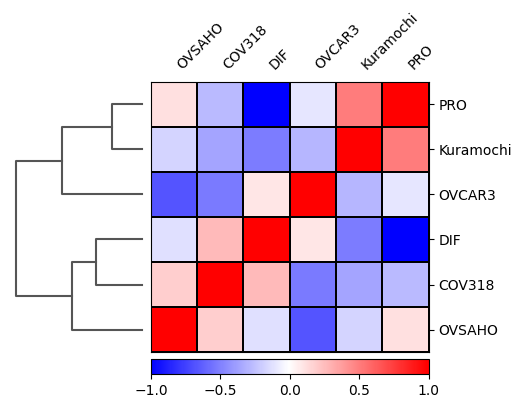

In [21]:
sc.pl.correlation_matrix(norm_adata, groupby="subtype")

62-1       GSE192898
109-1      GSE192898
253-1      GSE192898
311-1      GSE192898
765-1      GSE192898
             ...    
27094-1    GSE165897
27095-1    GSE165897
27096-1    GSE165897
27098-1    GSE165897
27099-1    GSE165897
Name: GSE_ID, Length: 5773, dtype: string

In [38]:
plot_col = norm_adata.obs.subtype
plot_col = pd.Series(norm_adata.obs.subtype, dtype="string")

replace_val = pd.Series(norm_adata.obs.GSE_ID.iloc[np.where(norm_adata.obs.GSE_ID != "GSE282041")[0]], dtype="string")
plot_col[np.where(norm_adata.obs.GSE_ID != "GSE282041")[0]] = replace_val
norm_adata.obs["plot_col"] = plot_col
norm_adata.obs.plot_col = pd.Series(norm_adata.obs.plot_col, dtype="category")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/natalie/.pyenv/versions/3.12.7/lib/python3.12/contextlib.py:144: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


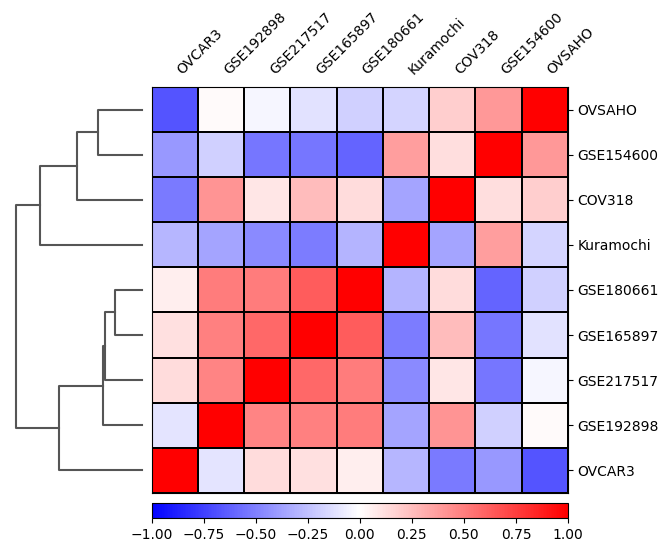

In [40]:
sc.pl.correlation_matrix(norm_adata[np.where(norm_adata.obs.subtype != "PRO")[0]], groupby="plot_col")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/natalie/.pyenv/versions/3.12.7/lib/python3.12/contextlib.py:144: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


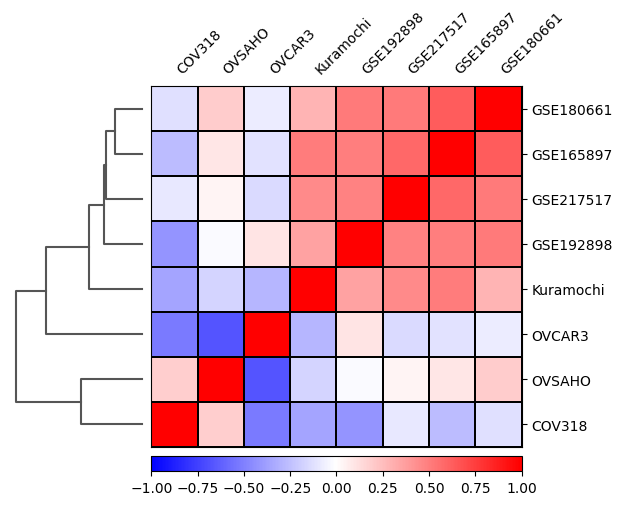

In [41]:
sc.pl.correlation_matrix(norm_adata[np.where(norm_adata.obs.subtype != "DIF")[0]], groupby="plot_col")

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/natalie/.pyenv/versions/3.12.7/lib/python3.12/contextlib.py:144: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


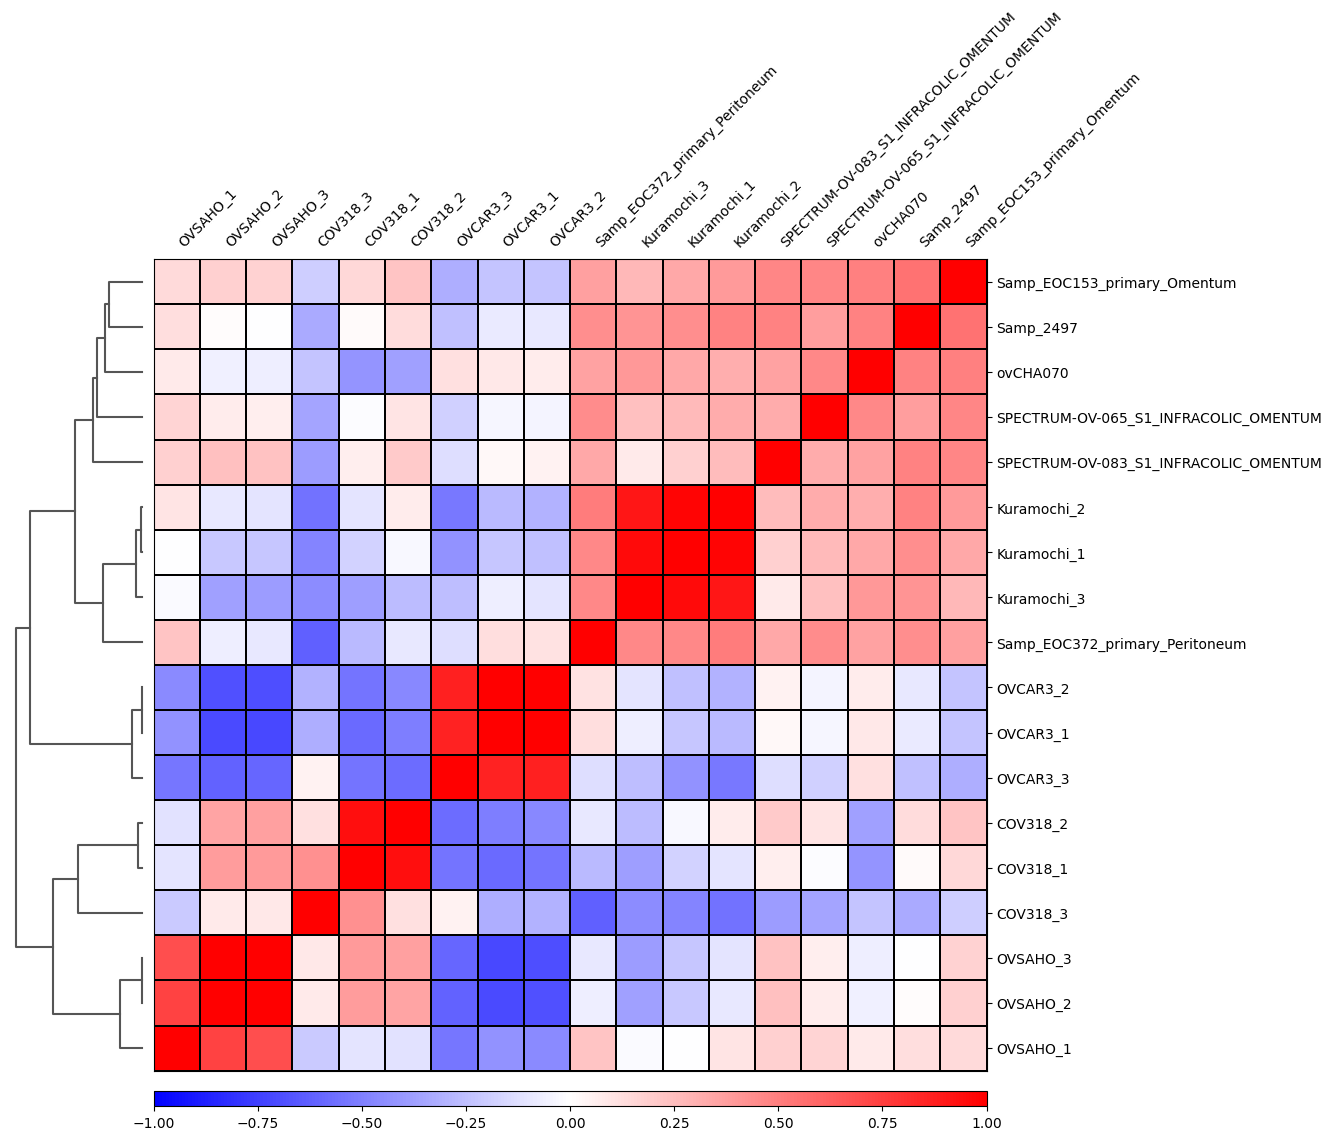

In [26]:
sc.pl.correlation_matrix(norm_adata[np.where(norm_adata.obs.subtype != "DIF")[0]], groupby="sample_id")